In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
from matplotlib import pyplot
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

import pandas_datareader as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

import datetime as dt
from IPython.display import display, HTML

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\fix_yahoo_finance\__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


In [2]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping

In [26]:
# web scrap closing price from 1/1/2016 to the most recent day for every stock
stockNames = ['INTC', 'ORCL', 'MSFT', 'HON', 'CSCO', 'AMD', 'AAPL']

def get_stock(stock, start, end):
    return pdr.get_data_yahoo(stock, start, end)['Close']

stocks = []
#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2017, 11, 9))))

## Data Pre-Processing

In [27]:
#size of window
num_lags = 1
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,INTC_0,INTC_1,ORCL_1,MSFT_1,HON_1,CSCO_1,AMD_1,AAPL_1
Date,,,,,,,,
2017-11-03,-0.263681,0.117744,-0.079800,0.076244,0.319196,-0.119306,0.342685,0.115247
2017-11-06,0.107794,-0.263681,-0.014962,-0.096133,0.186554,0.171368,0.430862,0.569076
2017-11-07,0.014924,0.107794,0.064839,-0.043093,0.340821,0.032538,0.647295,0.191124
2017-11-08,-0.038142,0.014924,0.032419,-0.160222,0.447509,0.054231,0.370741,0.020758
2017-11-09,-0.144279,-0.038142,0.022444,-0.051933,0.234131,0.101952,0.186373,0.145312


In [28]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 21
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training

In [29]:
#define model
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.05)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=300, batch_size=batch_size, shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (21, 10)                  720       
_________________________________________________________________
activation_5 (Activation)    (21, 10)                  0         
_________________________________________________________________
dense_5 (Dense)              (21, 1)                   11        
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
315/315 [==============================] - 0s - loss: 0.0444      
Epoch 2/300
315/315 [==============================] - 0s - loss: 0.0213     
Epoch 3/300
315/315 [==============================] - 0s - loss: 0.0184     
Epoch 4/300
315/315 [==============================] - 0s - loss: 0.0179     
Epoch 5/300
315/315 [==============================] - 0s - loss: 0.0178     
Epoch 6/300
315/3

315/315 [==============================] - 0s - loss: 0.0177     
Epoch 96/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 97/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 98/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 99/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 100/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 101/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 102/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 103/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 104/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 105/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 106/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 107/300
315/315 [==============================] - 0

315/315 [==============================] - 0s - loss: 0.0177     
Epoch 198/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 199/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 200/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 201/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 202/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 203/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 204/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 205/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 206/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 207/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 208/300
315/315 [==============================] - 0s - loss: 0.0177     
Epoch 209/300
315/315 [==============================]

315/315 [==============================] - 0s - loss: 0.0177     
Epoch 300/300
315/315 [==============================] - 0s - loss: 0.0177     


## Training Outcome

In [30]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(10, batch_input_shape=(new_batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, kernel_regularizer=regularizers.l2(0.01)))
new_model.add(Activation('relu'))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.05)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

Training RMSE: 0.0519


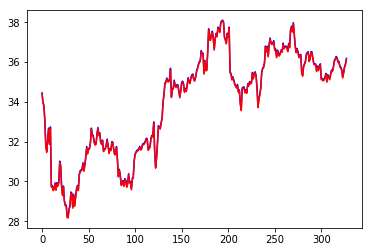

In [31]:
pyplot.plot(stocks[0].iloc[:training_size, :].values, color = "blue")
pyplot.plot(training_predictions, color = "red")
pyplot.show()

## Test Outcome

In [32]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.4588


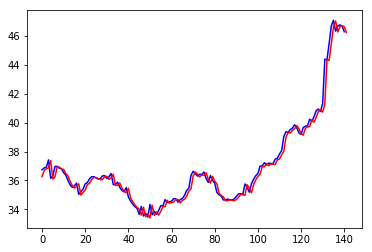

In [33]:
pyplot.plot(stocks[0].iloc[training_size+1:, :].values, color = "blue")
pyplot.plot(test_predictions, color = "red")
pyplot.show()

## Forecasted Price

In [34]:
print("Closing Price 9/11/2017")
print(stocks[0].iloc[-1:,:1].values[0][0])
print('\n')
print("Predicted Closing Price on 10/11/2017")
print(test_predictions[-1][0])

Closing Price 9/11/2017
46.299999


Predicted Closing Price on 10/11/2017
46.2481
